<a href="https://colab.research.google.com/github/UMA314159/-morning4-Image-Classification/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#google ColabのDriveモジュールをインポートして、Googleドライブをマウントする許可を実行する。
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
#データ処理ライブラリ
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score

# 画像処理ライブラリ
import cv2
from PIL import Image

#可視化ライブラリ
import matplotlib.pyplot as plt

#keras
import keras as ks
from keras.models import Sequential
from keras.layers import Dense , Dropout , Flatten , Conv2D , MaxPooling2D , BatchNormalization , Activation
from keras.utils import np_utils
from keras.initializers import he_normal
from keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array , array_to_img
from keras import regularizers
from keras import optimizers
import keras.activations

#学習済みモデルVGG16
from keras.applications.vgg16 import VGG16

#Pythonモジュール
import os
import glob

#表示設定
pd.options.display.max_rows = 78
pd.options.display.max_columns = 78

In [4]:
# データの読み込み
train_Y = pd.read_csv('/content/drive/MyDrive/data/train_master.tsv', delimiter='\t')
# ラベル名の削除
train_Y = train_Y.drop('file_name', axis=1)
# カテゴリー変数へ変換
Y = np_utils.to_categorical(train_Y,10)
print(Y.shape)

(5000, 10)


In [7]:
#train_imagesディレクトリ内のデータをリストに格納
train_file = glob.glob('/content/drive/MyDrive/data/train_images/train_images/t*')
len(train_file)

5000

In [8]:
# 番号順に並び替える関数
import re
from collections import OrderedDict

def sortedStringList(array=[]):
    sortDict=OrderedDict()
    for splitList in array:
        sortDict.update({splitList:[int(x) for x in re.split("(\d+)",splitList)if bool(re.match("\d*",x).group())]})
    return [sortObjKey for sortObjKey,sortObjValue in sorted(sortDict.items(), key=lambda x:x[1])]

sort_file = sortedStringList(train_file)
sort_file[:5]

['/content/drive/MyDrive/data/train_images/train_images/train_0.jpg',
 '/content/drive/MyDrive/data/train_images/train_images/train_1.jpg',
 '/content/drive/MyDrive/data/train_images/train_images/train_2.jpg',
 '/content/drive/MyDrive/data/train_images/train_images/train_3.jpg',
 '/content/drive/MyDrive/data/train_images/train_images/train_4.jpg']

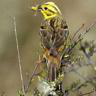

In [9]:
image = load_img(sort_file[0])
image

In [11]:
#画像の前処理
X = []
for img in sort_file:
    #画像ファイルの読み込み
    image = load_img(img)
    #画像ファイルのnumpy化　＋　正規化
    image = img_to_array(image) / 255.0
    #リストへ格納
    X.append(image)
    if len(X) % 1000 == 0:
        print(len(X))


#リストデータをnumpy化
X_np = np.array(X)
print(X_np.shape)
print(X_np.dtype)

1000
2000
3000
4000
5000
(5000, 96, 96, 3)
float32


In [12]:
#データの分割
X_train , X_test , Y_train , Y_test = train_test_split(X_np , Y , test_size=0.3 , random_state=1)
X_train , X_valid , Y_train , Y_valid = train_test_split(X_train , Y_train , test_size=0.3 , random_state=1)

#形状を確認
print('Y_train=' , Y_train.shape , 'X_train=' , X_train.shape)
print('Y_valid=' , Y_valid.shape , 'X_valid=' , X_valid.shape)
print('Y_test=' , Y_test.shape , 'X_test=' , X_test.shape)

Y_train= (2450, 10) X_train= (2450, 96, 96, 3)
Y_valid= (1050, 10) X_valid= (1050, 96, 96, 3)
Y_test= (1500, 10) X_test= (1500, 96, 96, 3)


In [13]:
image_gen = ImageDataGenerator(
    rotation_range=45, #45°回転
    horizontal_flip=True #水平移動
)

#元となるデータ数を増やす
X_gen = image_gen.flow(X_train, Y_train, batch_size=32)

#画像データを格納
X = []
#ラベルデータを格納
Y = []

for _ in range(10):
    #データ生成
    X_gen_new , y_gen_new = X_gen.__next__()
    #データを結合
    X_train = np.concatenate([X_train , X_gen_new])
    Y_train = np.concatenate([Y_train , y_gen_new])
    X.append(X_train)
    Y.append(Y_train)
    #データサイズを表示
    print(X_train.shape , Y_train.shape)

(2482, 96, 96, 3) (2482, 10)
(2514, 96, 96, 3) (2514, 10)
(2546, 96, 96, 3) (2546, 10)
(2578, 96, 96, 3) (2578, 10)
(2610, 96, 96, 3) (2610, 10)
(2642, 96, 96, 3) (2642, 10)
(2674, 96, 96, 3) (2674, 10)
(2706, 96, 96, 3) (2706, 10)
(2738, 96, 96, 3) (2738, 10)
(2770, 96, 96, 3) (2770, 10)


In [14]:
X_train = X[-1]
Y_train = Y[-1]
print(X_train.shape , Y_train.shape)

(2770, 96, 96, 3) (2770, 10)


In [15]:
#1行5列のグリッド形式で画像をプロットする関数
def plotImages(images_arr):
     fig , axes = plt.subplots(1,5,figsize=(20,20))
     axes = axes.flatten()
     for img , ax in zip( images_arr , axes):
         ax.imshow(img)
         ax.axis('off')
     plt.tight_layout()
     plt.show()

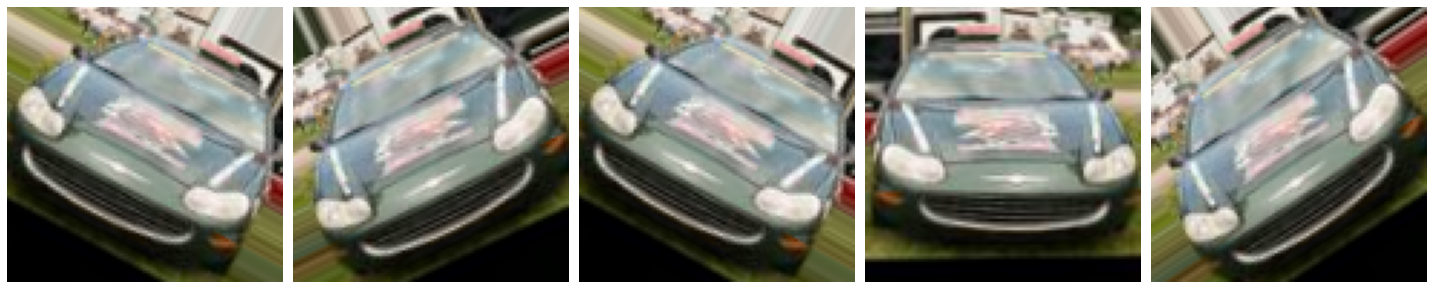

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [16]:
#教師データをまとめる
train_data_gen = image_gen.flow(X_train , Y_train , batch_size=32, shuffle=False)
augmented_images = [train_data_gen[15][0][31] for i in range(5)]

#表示
plotImages(augmented_images)
train_data_gen[15][1][31]

In [17]:
#検証データも教師データと同じ形へ変更
valid_gen = ImageDataGenerator()
valid_data_gen = valid_gen.flow(X_valid , Y_valid , batch_size=32)

In [28]:
from keras import layers

#kerasを使ったResNet-34CNNの実装
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding='same', use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding='same', use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding='same', use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[96,96,3],padding='same', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

ValueError: ignored

In [ ]:
#モデルコンパイル　確率的勾配効果法
model1.compile(loss='categorical_crossentropy',
               optimizer= 'sgd',
               metrics=['accuracy'])

In [ ]:
#EarlyStoppingの設定
from keras.callbacks import EarlyStopping
callbacks = EarlyStopping(monitor='val_loss' , patience=50)

In [ ]:
#モデルの訓練
log = model1.fit_generator(train_data_gen,
                 steps_per_epoch=len(X_train) / 32,
                 epochs=1500,
                 callbacks = [callbacks],
                 validation_data=(X_valid , Y_valid))

In [ ]:
image_test_features = np.load('/content/drive/MyDrive/data/test_X_features.npy')

In [ ]:
image_test_features = image_test_features.astype('float32')
image_test_features /= 255
image_test_features = image_test_features.reshape(image_test_features.shape[0] , 96 , 96 , 3)

In [ ]:
pred_y = model1.predict(image_test_features)
pred_y = np.argmax(pred_y , axis=1)

In [ ]:
#sampl_submitデータ
sample = pd.read_table('/content/drive/MyDrive/data/sample_submit.tsv' , index_col = 0 , header=None)
sample[1] = pred_y
sample

,1
0,
test_0.jpg,1
test_1.jpg,1
test_2.jpg,1
test_3.jpg,0
test_4.jpg,4
...,...
test_7995.jpg,9
test_7996.jpg,4
test_7997.jpg,1


In [ ]:
sample.to_csv('/content/drive/MyDrive/Colab Notebooks/-morning4-SIGNATE-画像ラベリング/submit/submit_3.tsv' ,sep='\t' , header=None)